<a href="https://colab.research.google.com/github/itssanchayita/mlproject/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importing Required Libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

2. **Reading and understanding our data**

In [ ]:
df = pd.read_csv('/Combined Data.csv.zip', index_col=0)

In [ ]:
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [ ]:
df.describe()


,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df.isna().sum()

,0
statement,362
status,0


In [ ]:
df.dropna(inplace = True)
df.isna().sum()

,0
statement,0
status,0


In [ ]:
df.status.value_counts()

,count
status,
Normal,16343
Depression,15404
Suicidal,10652
Anxiety,3841
Bipolar,2777
Stress,2587
Personality disorder,1077


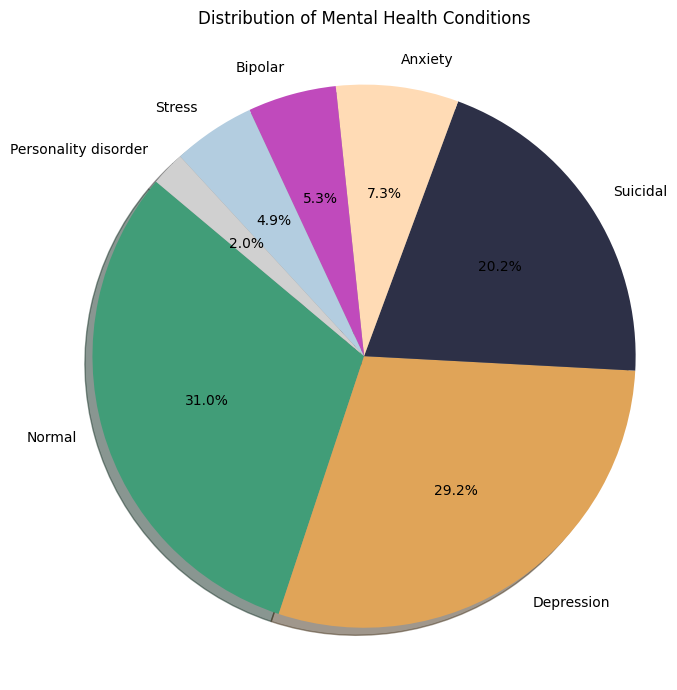

In [ ]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()


In [ ]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")


Status: Anxiety
Statement: Shivering and woke up with numb arm. First before I went to bed my body made some sort of random farting noise while I was moving which worried me because I couldn't figure out what it was. then I wakeup to find my right arm numb and my heart rate briefly sped up. Now I'm twitching instead of shivering, usually the cold does not cause me to react that way. I want to think they are not connected but... 

Status: Bipolar
Statement: Experiences with lamictal After being on 25 mg for two weeks, I've now been on 50 mg of lamictal for almost two weeks. I'm going to move to 75 mg soon, which (according to my psychiatrist) is when I should start to feel something. 

Just wanted to know what everyone's experiences were. I've had some pretty terrible experiences with medications in the past. Zoloft made me go manic (which is what caused my psychiatrist to realize that I probably have bipolar tendencies). Another one which I've had (I cannot remember the name of it -- i

In [ ]:
nltk.download('punkt_tab')
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [ ]:
df[df['num_of_characters'] > 10000]


,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


3.TEXT PROCESSING


In [ ]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [ ]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [ ]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


3.4. Stemming

Reduce words to their base or root form. However, in some cases, the stemming process produces words that are not correct spellings of the root word. For example, happi and sunni. That's because it chooses the most common stem for related words. For example, we can look at the set of words that comprises the different forms of happy:

happy
happiness
happier
We can see that the prefix happi is more commonly used. We cannot choose happ because it is the stem of unrelated words like happen.

In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.head()


,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


3.5. Stop Words

While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

3.6 Word Clouds

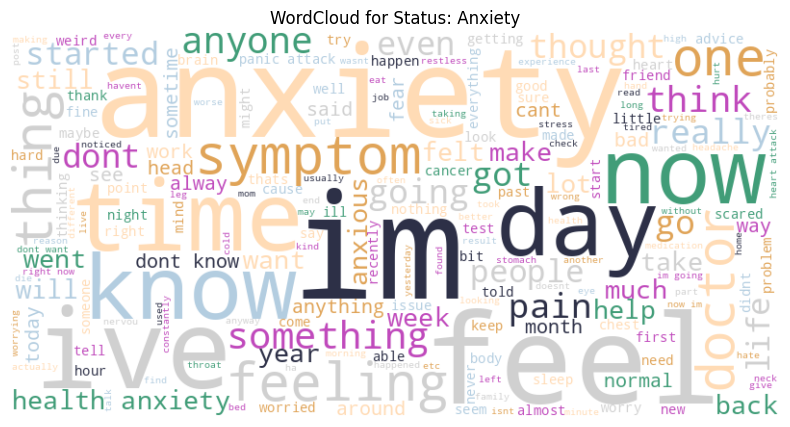

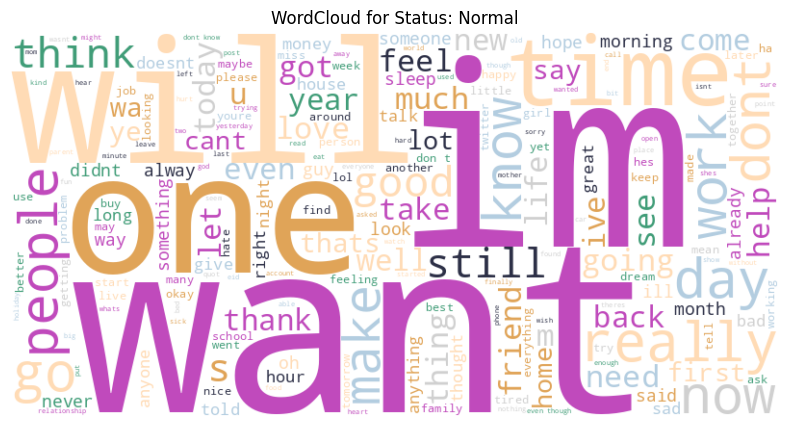

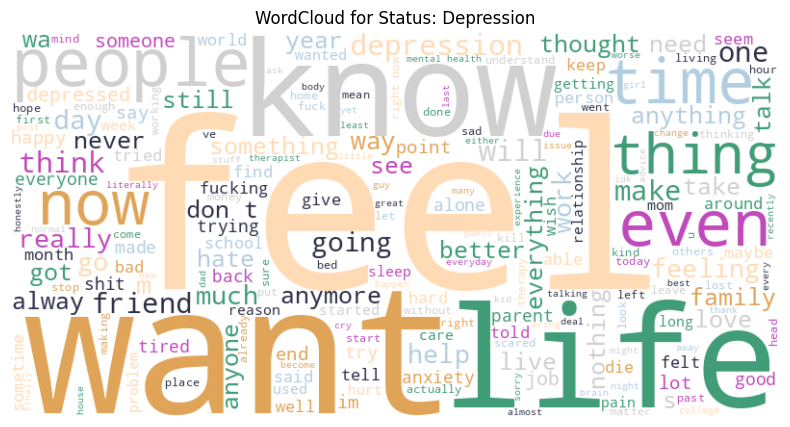

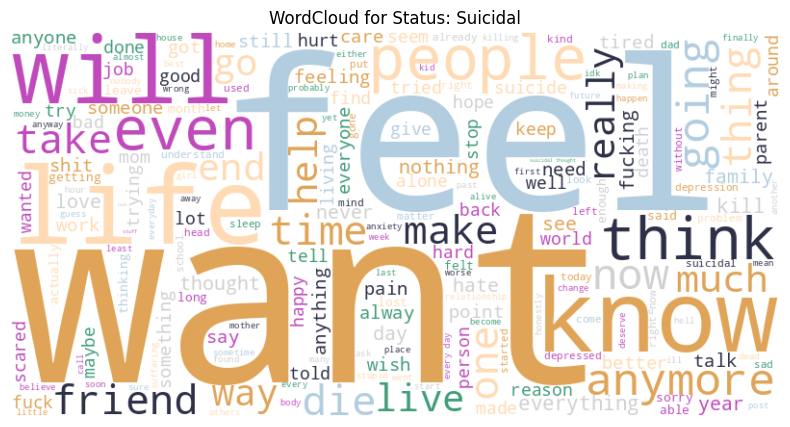

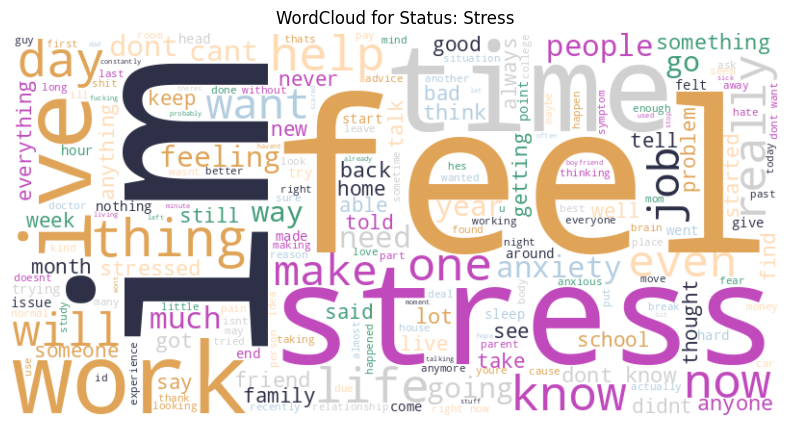

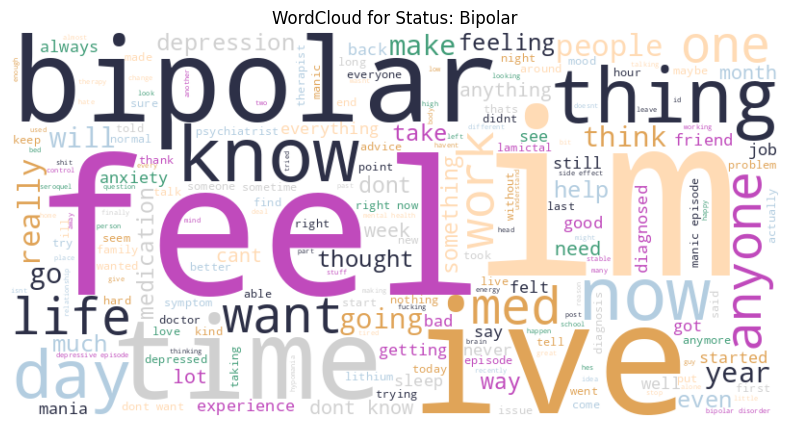

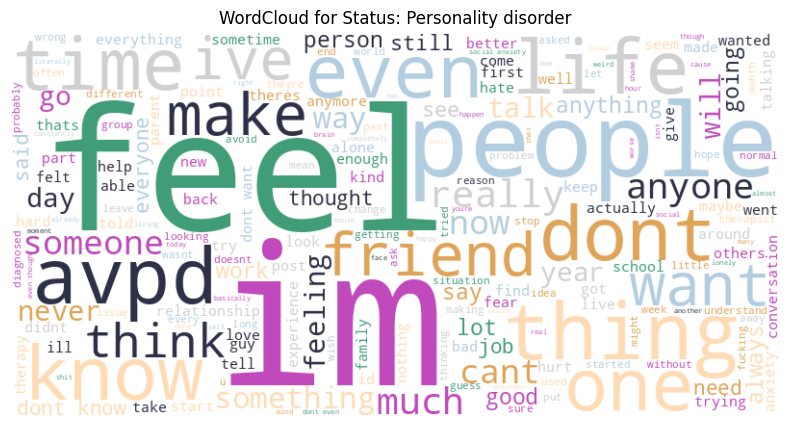

In [ ]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)

    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

Data PreProcessing

In [ ]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']


In [ ]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

4.4. Convert text to features using TF-IDF vectoriser

Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.



In [ ]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])
print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [ ]:
X_train_combined.shape

(42144, 50002)

Resampling

We experimented with various resampling techniques, including SMOTE, Random Over-Sampling and Random Under-Sampling. Among these, Random Over-Sampling provided the best results.

In [ ]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [ ]:
X_train_resampled.shape

(91742, 50002)

5. Model Training

In [ ]:
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101),
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, tree_method='hist')
}


Evaluating: Bernoulli Naive Bayes
Accuracy: 0.6406

                      precision    recall  f1-score   support

             Anxiety       0.66      0.60      0.63       768
             Bipolar       0.70      0.58      0.64       566
          Depression       0.66      0.48      0.55      3050
              Normal       0.67      0.93      0.78      3237
Personality disorder       0.86      0.34      0.49       202
              Stress       0.41      0.51      0.46       530
            Suicidal       0.59      0.54      0.56      2184

            accuracy                           0.64     10537
           macro avg       0.65      0.57      0.59     10537
        weighted avg       0.64      0.64      0.63     10537



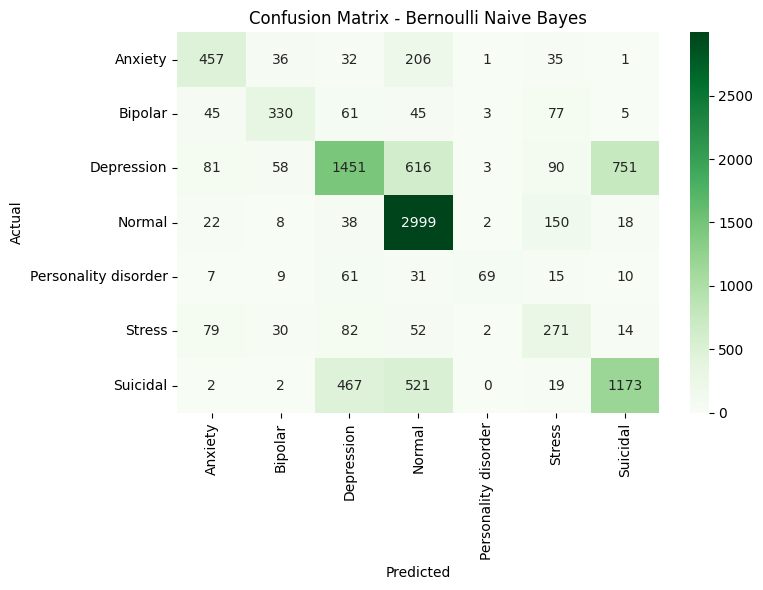

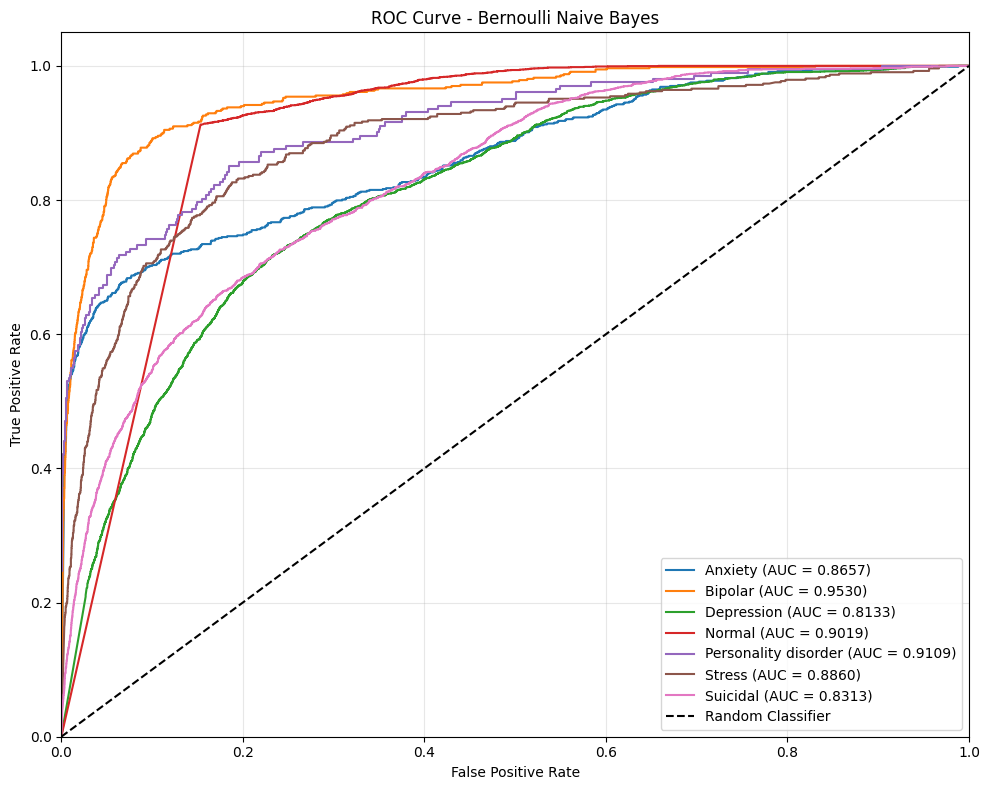

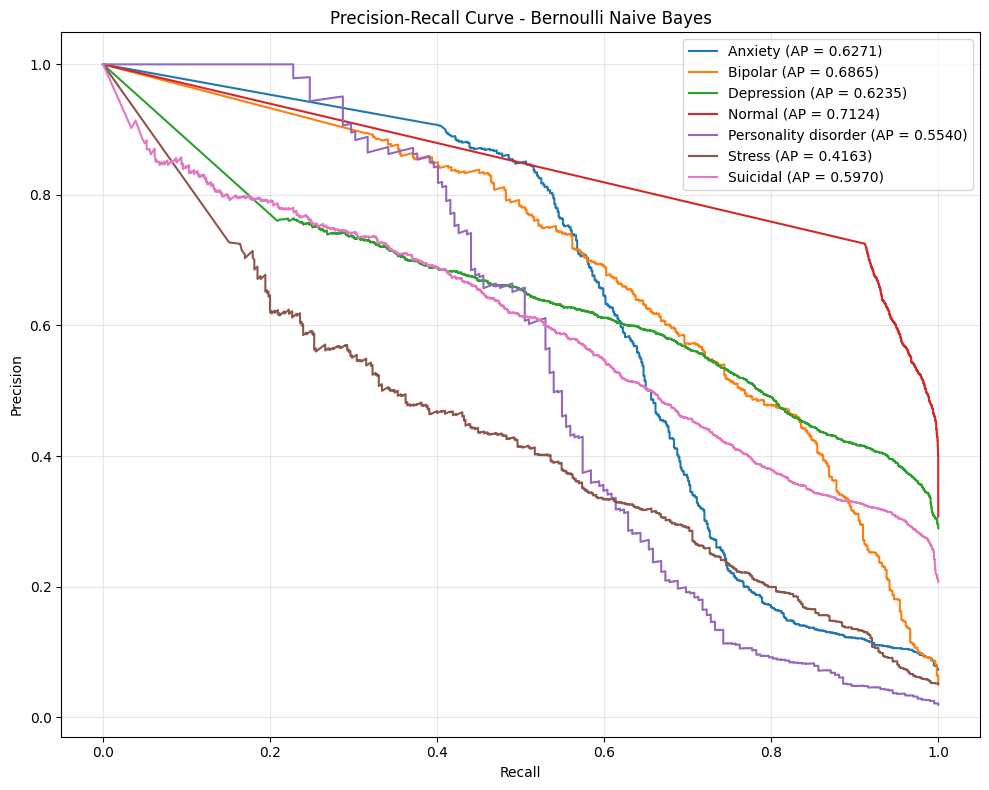


Evaluating: Decision Tree
Accuracy: 0.6185

                      precision    recall  f1-score   support

             Anxiety       0.69      0.55      0.61       768
             Bipolar       0.45      0.64      0.52       566
          Depression       0.80      0.34      0.48      3050
              Normal       0.87      0.85      0.86      3237
Personality disorder       0.58      0.43      0.49       202
              Stress       0.24      0.80      0.37       530
            Suicidal       0.52      0.66      0.58      2184

            accuracy                           0.62     10537
           macro avg       0.59      0.61      0.56     10537
        weighted avg       0.70      0.62      0.62     10537



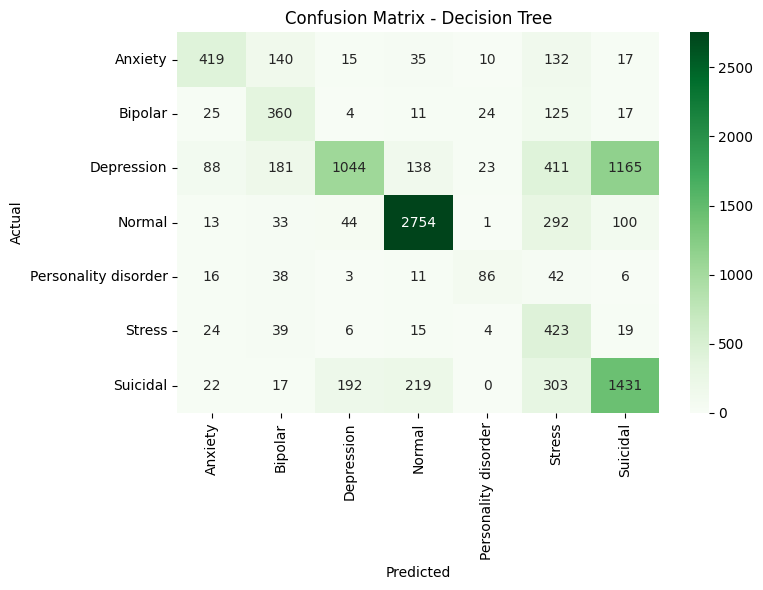

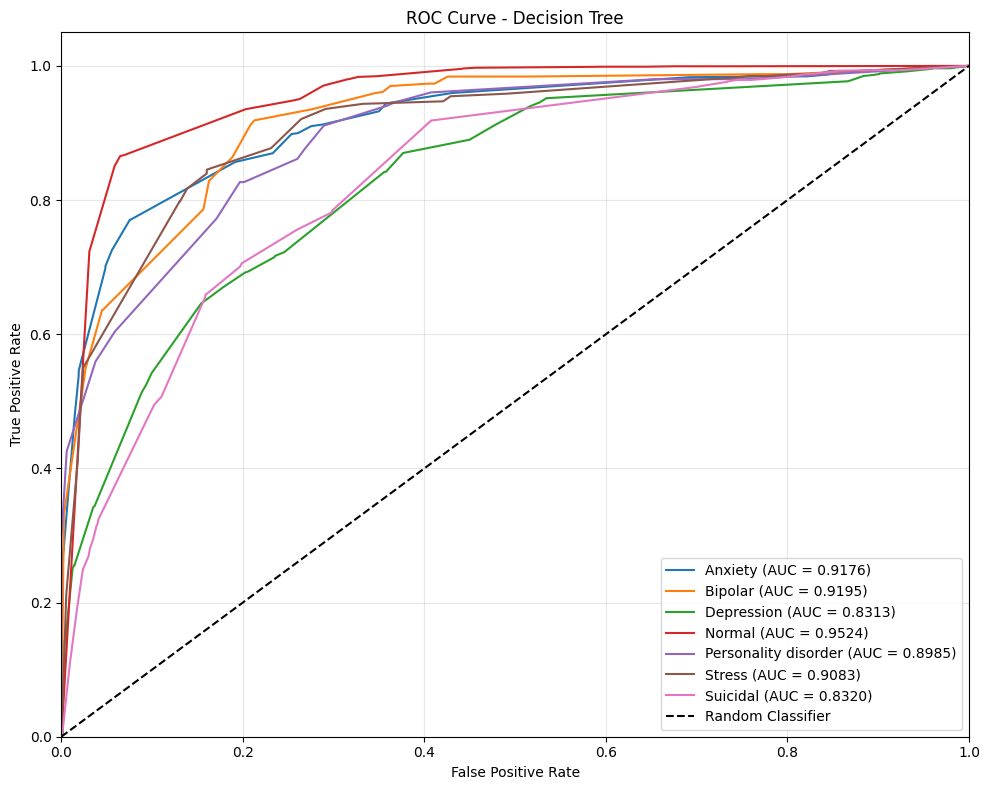

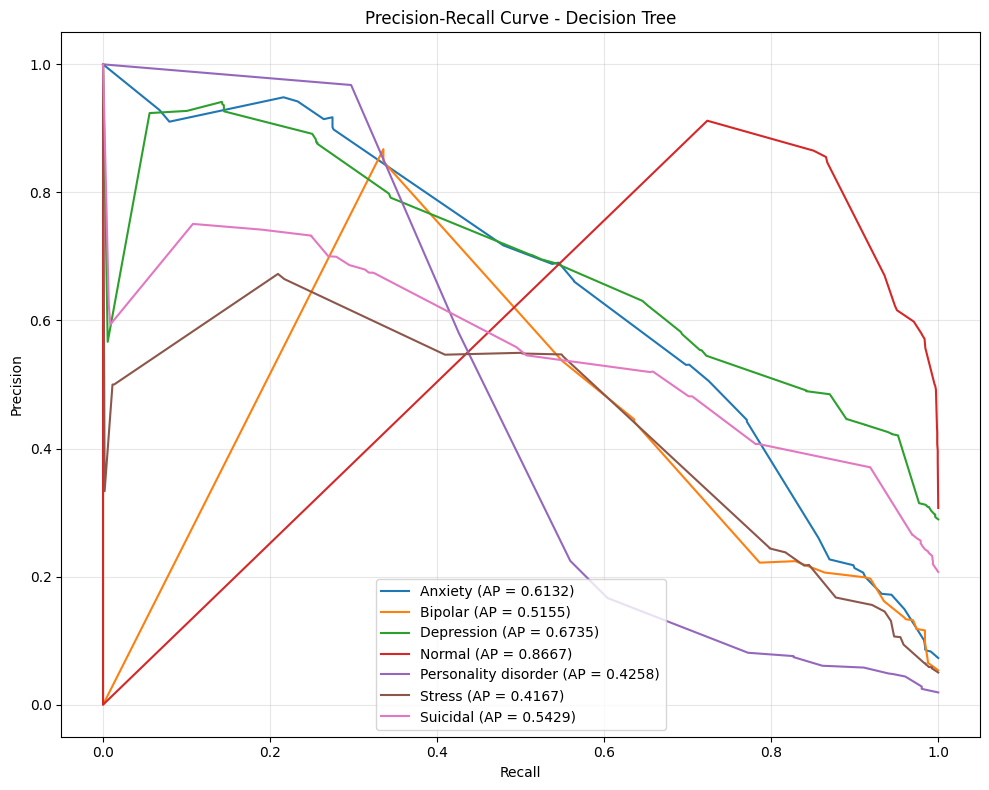

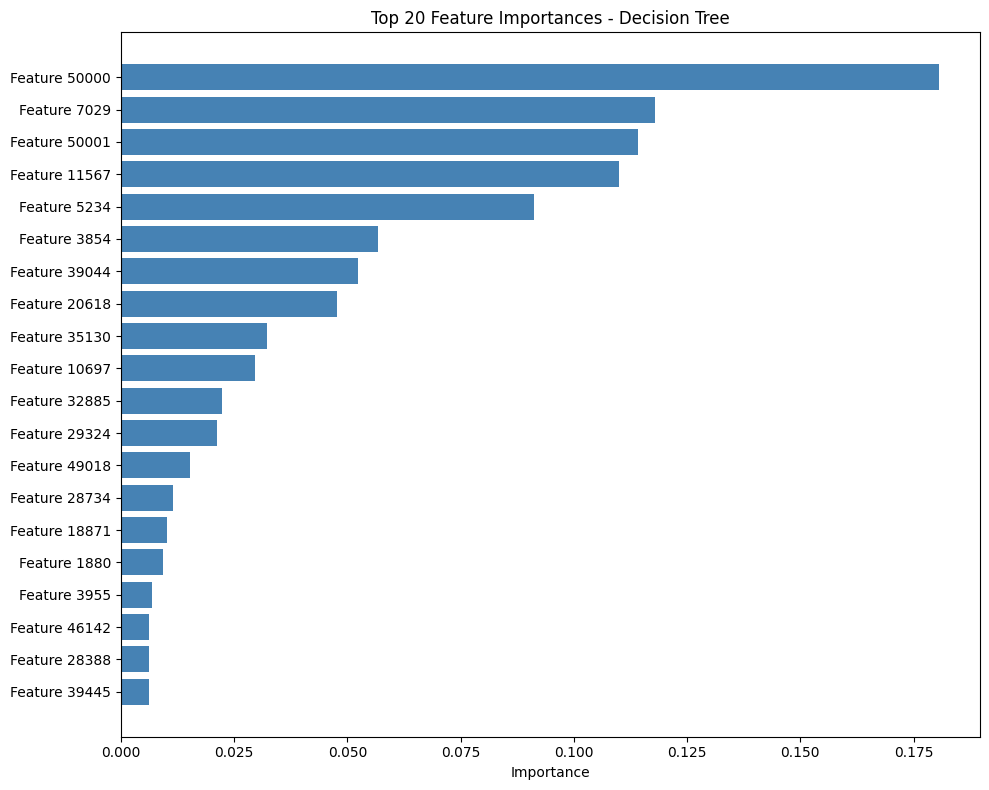


Evaluating: Logistic Regression
Accuracy: 0.7632

                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       768
             Bipolar       0.84      0.79      0.81       566
          Depression       0.71      0.67      0.69      3050
              Normal       0.90      0.92      0.91      3237
Personality disorder       0.71      0.65      0.68       202
              Stress       0.60      0.65      0.62       530
            Suicidal       0.65      0.68      0.66      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.74      0.74     10537
        weighted avg       0.76      0.76      0.76     10537



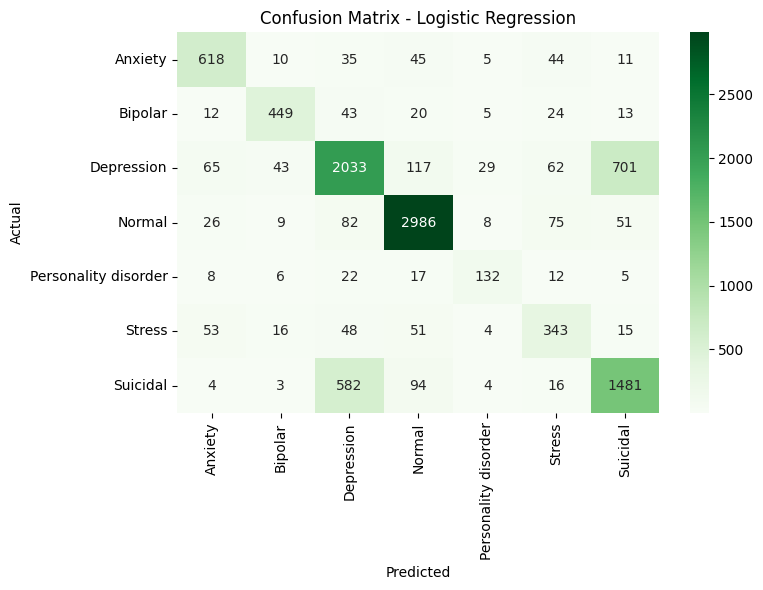

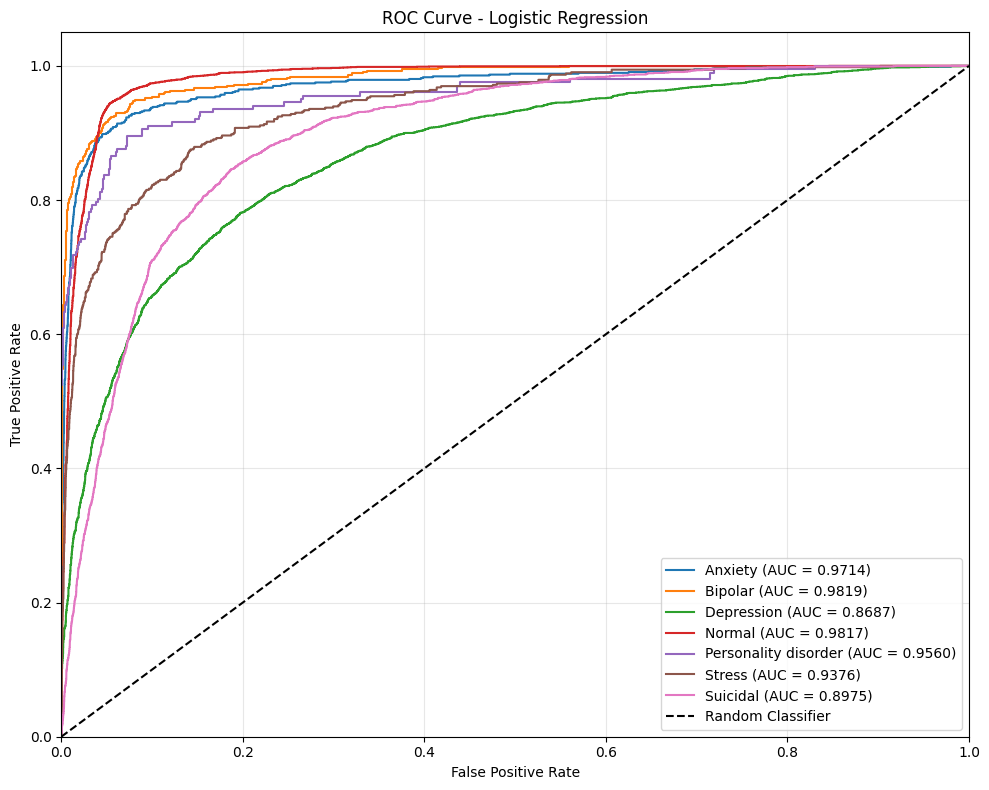

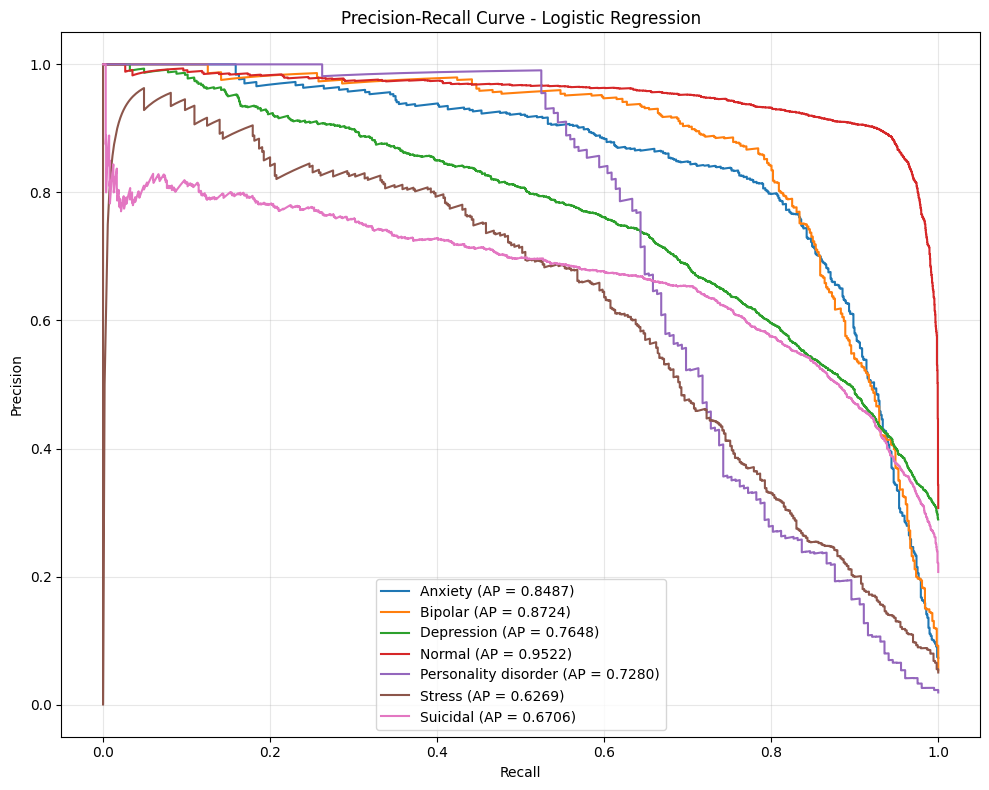


Evaluating: XGB


XGBoostError: Invalid Input: 'gpu_hist', valid values are: {'approx', 'auto', 'exact', 'hist'}

In [ ]:
# Enhanced evaluation with multiple metrics and visualizations
from sklearn.metrics import (roc_curve, auc, precision_recall_curve,
                            average_precision_score, roc_auc_score)
import matplotlib.pyplot as plt
import numpy as np

# Store results for comparison
results = {}

for name, clf in classifiers.items():
    print(f"\n{'='*60}")
    print(f"Evaluating: {name}")
    print('='*60)

    # Fit model
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    y_pred_proba = clf.predict_proba(X_test_combined)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    # Classification report
    labels = lbl_enc.classes_
    print("\n" + classification_report(y_test, y_pred, target_names=labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.tight_layout()
    plt.show()

    # ROC-AUC Curve (for binary or one-vs-rest for multiclass)
    plt.figure(figsize=(10, 8))
    n_classes = len(labels)

    if n_classes == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    else:
        # Multiclass - One vs Rest
        y_test_bin = label_binarize(y_test, classes=range(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    plt.figure(figsize=(10, 8))
    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
        avg_precision = average_precision_score(y_test, y_pred_proba[:, 1])
        plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
    else:
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
            avg_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
            plt.plot(recall, precision, label=f'{labels[i]} (AP = {avg_precision:.4f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Feature Importance (for tree-based models)
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        indices = np.argsort(importances)[-20:]  # Top 20 features

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(indices)), importances[indices], color='steelblue')
        plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
        plt.xlabel('Importance')
        plt.title(f'Top 20 Feature Importances - {name}')
        plt.tight_layout()
        plt.show()

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'model': clf
    }

# Model Comparison Bar Chart
plt.figure(figsize=(10, 6))
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
plt.bar(model_names, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim([min(accuracies) - 0.05, 1.0])
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame to store classifier names and their corresponding accuracy scores
accuracies_df = pd.DataFrame({'Classifier': classifiers.keys(), 'Accuracy': accuracy_scores}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(12, 8))
palette = dict(zip(accuracies_df['Classifier'], colors[:4]))

# Create a bar plot to visualize the accuracy of each classifier
sns.barplot(x='Classifier', y='Accuracy', data=accuracies_df, palette=palette)

plt.title("Classifier Accuracy Comparison")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

ValueError: All arrays must be of the same length